# Experiments
This is the first iteration of scrappy experiments for EDA: to emulate the data generating process, generate plots, observe trends and get a sense of the datasets

In [48]:
import numpy as np

# Constants for calculating salinity and salinity correction factor

# Coefficients for the polynomial used in the calculation of salinity
a = [0.008, -0.1692, 25.3851, 14.0941, -7.0261, 2.7081]
b = [0.0005, -0.0056, -0.0066, -0.0375, 0.0636, -0.0144]

# Constant used in the calculation of salinity
k = 0.0162

# Coefficients for the polynomial used in the calculation of rT
C = [6.766097e-01, 2.005640e-02, 1.104259e-04, -6.969800e-07, 1.003100e-09]

# Coefficients for the polynomial used in the calculation of Salinity Correction Factor
B = [-6.246090e-3, -7.423444e-3, -1.048635e-2, -7.987907e-3]

# Constant used in the calculation of Salinity Correction Factor
C0 = -4.679983e-7

In [57]:
# define all the functions
def calculate_Rt(CS_t: float, T: float) -> float:
    """
    Calculate Rt which is the ratio of specific conductance to rT.

    Parameters:
    CS_t (float): Specific Conductance
    T (float): Water temperature in degrees C

    Returns:
    float: The calculated Rt value
    """

    R = CS_t / 42.914
    rT = sum([C[i] * (T**i) for i in range(len(C))])
    return R / rT


def calculate_salinity(CS_t: float, T: float, a: list, b: list, k: float) -> float:
    """
    Calculate Salinity based on specific conductance and temperature.

    Parameters:
    CS_t (float): Specific Conductance
    T (float): Water temperature in degrees C
    a (list): Coefficients a for the salinity calculation
    b (list): Coefficients b for the salinity calculation
    k (float): Coefficient k for the salinity calculation

    Returns:
    float: The calculated salinity value
    """
    

    Rt = calculate_Rt(CS_t, T)
    
    # Calculation for the first part of the salinity
    first_part = sum([a[i] * (Rt ** (0.5 * i)) for i in range(6)])
    
    # Calculation for the second part (inside the parentheses)
    second_part = sum([b[i] * (Rt ** (0.5 * i)) for i in range(6)])
    
    salinity = first_part + (T - 15) * second_part / (1 + k * (T - 15))

    return salinity



def calculate_TS(TC: float) -> float:
    """
    Calculate TS which is a function of temperature.

    Parameters:
    TC (float): Temperature in degrees C

    Returns:
    float: The calculated TS value
    """
    return np.log((298.15 - TC) / (273.15 + TC))


def calculate_SC(S: float, TC: float) -> float:
    """
    Calculate Salinity Correction Factor based on salinity and temperature.

    Parameters:
    S (float): Salinity
    TC (float): Temperature in degrees C

    Returns:
    float: The calculated Salinity Correction Factor
    """
    TS = calculate_TS(TC)
    ln_SC = S * sum([B[i] * (TS**i) for i in range(len(B))]) + C0 * (S**2)
    return np.exp(ln_SC)

def fixed_calculate_salinity(CS_t):
    T = 25  # Water temperature in degrees C
    a0 = 0.008
    b0 = 0.0005
    a1 = -0.1692
    b1 = -0.0056
    a2 = 25.3851
    b2 = -0.0066
    a3 = 14.0941
    b3 = -0.0375
    a4 = -7.0261
    b4 = 0.0636
    a5 = 2.7081
    b5 = -0.0144
    C0 = 6.766097E-01
    C1 = 2.005640E-02
    C2 = 1.104259E-04
    C3 = -6.969800E-07
    C4 = 1.003100E-09

    k = 0.0162

    Rt = CS_t / (42.914 * (C0 + C1 * T + C2 * T**2 + C3 * T**3 + C4 * T**4))
    Salinity = a0 + a1 * Rt + a2 * Rt**2 + a3 * Rt**3 + a4 * Rt**4 + a5 * Rt**5
    Salinity *= k

    return Salinity


def adjusted_DO(DO_FIELD_CAL: float, CS_t: float, T: float) -> float:
    """
    Calculate adjusted dissolved oxygen concentration which takes into account salinity.

    Parameters:
    DO_FIELD_CAL (float): Field calibration of dissolved oxygen
    CS_t (float): Specific Conductance
    T (float): Water temperature in degrees C

    Returns:
    float: The adjusted dissolved oxygen concentration
    """
    # S = calculate_salinity(CS_t, T)
    S = fixed_calculate_salinity(CS_t)
    SC = calculate_SC(S, T)
    return DO_FIELD_CAL * SC


In [5]:
import pandas as pd

# B = pd.read_csv('~/downloads/B.csv')
# C_file = pd.read_csv('~/downloads/C.csv')
# D_file = pd.read_csv('/Users/christina/downloads/D.csv')
con_data = pd.read_csv('/Users/christina/Downloads/COMBB_data/Raw Data 6.9.23 RB1 xls/RB1_ConDL_6_9_2023_AH.csv')

In [71]:
# skip the rows with missing values
salinity = B['SALINITY (PPT)'][3:54].reset_index(drop=True)

In [72]:
spec_con = B['Spec Conduct (uS/cm)'][3:54].reset_index(drop=True)
spec_con.isna().sum()

0

In [73]:
water_temp = B['WaterTemp_C'][3:54].reset_index(drop=True)
water_temp.isna().sum()


0

In [74]:
for_salinity = zip(spec_con, water_temp)

In [81]:
calculated_salinity = []
for sc, t in for_salinity:
    calculated_salinity.append(calculate_salinity(sc, t))

In [101]:
calculate_salinity(45451.0,17.8, a, b, k)

76983080.80770177

In [82]:
calculated_salinity

[]

# Adj DO with Salinity ppt

In [127]:
def adjusted_DO(DO_FIELD_CAL: float, S: float, T: float) -> float:
    """
    Calculate adjusted dissolved oxygen concentration which takes into account salinity.

    Parameters:
    DO_FIELD_CAL (float): Field calibration of dissolved oxygen
    S (float): Salinity
    T (float): Water temperature in degrees C

    Returns:
    float: The adjusted dissolved oxygen concentration
    """
    SC = calculate_SC(S, T)
    return DO_FIELD_CAL * SC


In [128]:
C_file.columns

Index(['Date Time', 'DO conc (mg/L)  #20659182', 'Temp (°C)  #20659182',
       'DO Adj Conc (mg/L) c:1 2', 'DO Percent Sat (%)', 'Salinity (ppt)',
       'Coupler Attached', 'Stopped', 'End Of File'],
      dtype='object')

In [129]:
salinity = C_file['Salinity (ppt)'][2:1016]
DO_FIELD_CAL = C_file['DO conc (mg/L)  #20659182'][2:1016]
temp = C_file['Temp (°C)  #20659182'][2:1016]
adj_do = C_file['DO Adj Conc (mg/L) c:1 2'][2:1016]

In [103]:
adjusted_DO(7.84, 28.5172, 22.5)

6.647072084538437

In [130]:
calculated_adj_do = [adjusted_DO(do, s, t) for do, s, t in zip(DO_FIELD_CAL, salinity, temp)]
error = [abs(a - calc_a) for a, calc_a in zip(adj_do, calculated_adj_do)]

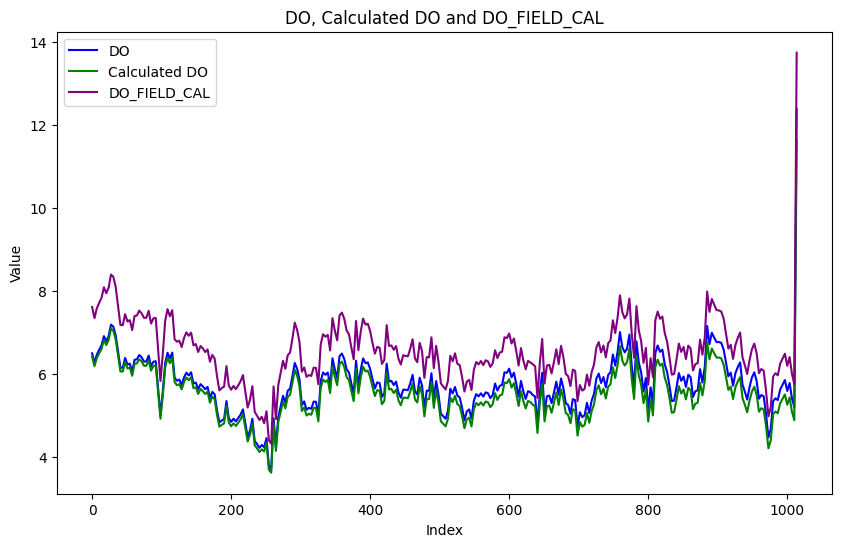

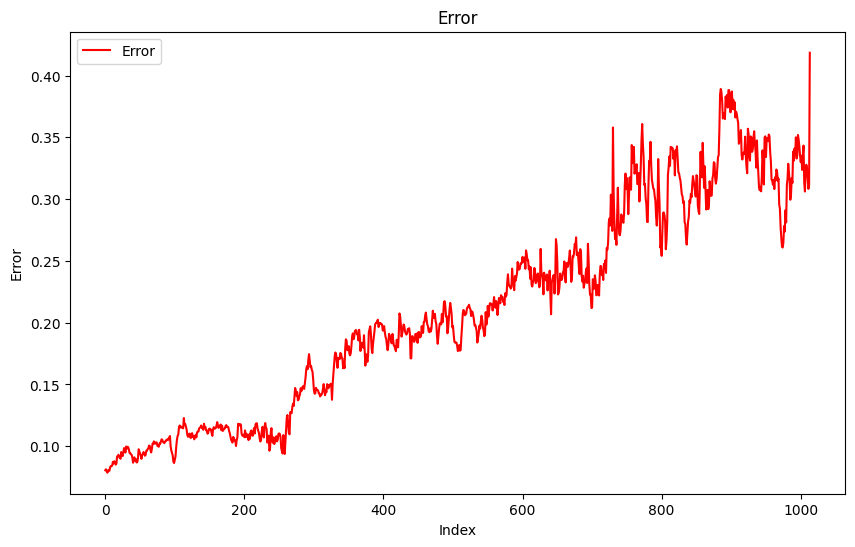

In [137]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

# Create a new figure for DO, Calculated DO and DO_FIELD_CAL
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Define x values
xnew = np.linspace(0, len(adj_do), 300)

# Make the plots smooth
spl_adj_do = make_interp_spline(range(len(adj_do)), adj_do, k=3)
spl_calculated_adj_do = make_interp_spline(range(len(calculated_adj_do)), calculated_adj_do, k=3)
spl_DO_FIELD_CAL = make_interp_spline(range(len(DO_FIELD_CAL)), DO_FIELD_CAL, k=3)

# Plot DO
ax1.plot(xnew, spl_adj_do(xnew), label='DO', color='blue')

# Plot calculated DO
ax1.plot(xnew, spl_calculated_adj_do(xnew), label='Calculated DO', color='green')

# Plot DO_FIELD_CAL
ax1.plot(xnew, spl_DO_FIELD_CAL(xnew), label='DO_FIELD_CAL', color='purple')

ax1.legend()

ax1.set_title('DO, Calculated DO and DO_FIELD_CAL')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')

plt.show()

# Create a new figure for Error
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(error, label='Error', color='red')
ax2.legend()
ax2.set_title('Error')
ax2.set_xlabel('Index')
ax2.set_ylabel('Error')
plt.show()

In [139]:
adj_do / DO_FIELD_CAL

2       0.853433
3       0.853148
4       0.853231
5       0.853012
6       0.853534
          ...   
1011    0.902805
1012    0.903288
1013    0.903696
1014    0.904025
1015    0.902850
Length: 1014, dtype: float64

# Experiment 2:

## STEP 1: calculate Specific conductivity from actual conductivity (labeled High Range in sheet)

With the formula in the sheet and output data from the hoboware pro software - you should be able to test if you can generate the same specific conductivity values from the raw actual conductivity values.

Paul hasn't provided me with what Onset uses for r = ?

From the data I calculated an r value (r = 0.0195054) - but even though I calculated it from the hoboware output - it isn't consistently giving me the correct specific conductivity values. 

I'll ask Paul again for the r value- but in the meantime you could see if you can calculate a consistent r from the data.  If you do, then you've got everything you need to generate specific conductivity from conductivity values. 

In [29]:
import pandas as pd

# con_data = pd.read_csv('../data/W12_Con_7_6_2023_lkg.csv')
con_data = pd.read_csv('/Users/christina/scc_db/data/RB1_ConDL_6_9_2023_AH.csv')

In [30]:
con_data = con_data[7:]

In [32]:
con_data

,#,"Date Time, GMT-04:00",LowRange,HighRange,temp
7,8,06/02/23 11:10:00 AM,33594.4,30064.6,22.22
8,9,06/02/23 11:20:00 AM,33594.4,30697.7,21.81
9,10,06/02/23 11:30:00 AM,33594.4,30687.6,21.70
10,11,06/02/23 11:40:00 AM,33594.4,30685.1,21.73
11,12,06/02/23 11:50:00 AM,33594.4,30712.8,21.73
...,...,...,...,...,...
1022,1023,06/09/23 12:20:00 PM,33594.4,30215.7,18.51
1023,1024,06/09/23 12:30:00 PM,33594.4,30208.4,18.54
1024,1025,06/09/23 12:40:00 PM,33594.4,29924.4,19.14
1025,1026,06/09/23 12:44:21 PM,NaN,NaN,NaN


In [35]:
AC_all = con_data['HighRange']
# spec_con = con_data['Specific Conductance (?S/cm)']

In [36]:
def specific_conductance(AC: float, T: float, r=0.19558593750000013) -> float:
    """
    Compute the specific conductance given conductivity, temperature, and coefficient r.
    return AC / (1 + r * (T - 25))

    Parameters:
    AC (float): Actual Conductivity of the sample in microSeimens / cm
    T (float): temperature of the sample in degrees C
    r (float): temperature correction coefficient

    Returns:
    float: Specific Conductance in microSeimens / cm
    """
    return AC / (1 + r * (T - 25))

# Calculate adj DO and compare with field cal

In [37]:
con_data['Specific Conductance'] = specific_conductance(AC_all, con_data['temp'])


In [38]:
con_data

,#,"Date Time, GMT-04:00",LowRange,HighRange,temp,Specific Conductance
7,8,06/02/23 11:10:00 AM,33594.4,30064.6,22.22,65891.967323
8,9,06/02/23 11:20:00 AM,33594.4,30697.7,21.81,81625.265511
9,10,06/02/23 11:30:00 AM,33594.4,30687.6,21.70,86549.654618
10,11,06/02/23 11:40:00 AM,33594.4,30685.1,21.73,85133.759108
11,12,06/02/23 11:50:00 AM,33594.4,30712.8,21.73,85210.610906
...,...,...,...,...,...,...
1022,1023,06/09/23 12:20:00 PM,33594.4,30215.7,18.51,-112178.924302
1023,1024,06/09/23 12:30:00 PM,33594.4,30208.4,18.54,-114649.342794
1024,1025,06/09/23 12:40:00 PM,33594.4,29924.4,19.14,-204774.270119
1025,1026,06/09/23 12:44:21 PM,NaN,NaN,NaN,NaN


In [42]:
DO_data = pd.read_csv('/Users/christina/scc_db/data/RB1_DODL_6_9_2023_AH.csv')
DO_data = DO_data[7:]

In [58]:
def adjusted_DO(DO_FIELD_CAL: float, CS_t: float, T: float) -> float:
    """
    Calculate adjusted dissolved oxygen concentration which takes into account salinity.

    Parameters:
    DO_FIELD_CAL (float): Field calibration of dissolved oxygen
    CS_t (float): Specific Conductance
    T (float): Water temperature in degrees C

    Returns:
    float: The adjusted dissolved oxygen concentration
    """
    # S = calculate_salinity(CS_t, T)
    S = fixed_calculate_salinity(CS_t)
    SC = calculate_SC(S, T)
    return DO_FIELD_CAL * SC

In [59]:
DO_data['Adjusted DO'] = adjusted_DO(DO_data['DO_conc'], con_data['Specific Conductance'], DO_data['temp'])


In [60]:
DO_data['Adjusted DO']

7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
       ... 
1022    0.0
1023    0.0
1024    0.0
1025    NaN
1026    NaN
Name: Adjusted DO, Length: 1020, dtype: float64

In [24]:
# Now we compute a an r using optimization method

from scipy.optimize import minimize

def objective_min(r: float, AC: pd.Series, T: pd.Series, actual_SC: pd.Series) -> float:
    """
    Objective function to minimize. Computes the sum of squared differences between
    actual and calculated specific conductance.

    Parameters:
    r (float): temperature correction coefficient
    AC (pd.Series): Series of Actual Conductivity values
    T (pd.Series): Series of temperature values
    actual_SC (pd.Series): Series of actual Specific Conductance values

    Returns:
    float: Sum of squared differences to be minimized
    """
    calculated_SC = AC / (1 + r * (T - 25))
    return ((calculated_SC - actual_SC) ** 2).sum()

# Initial guess for r
r_initial_guess = 0.01

# Use scipy.optimize.minimize to find the optimal r
result = minimize(
    objective_min, 
    r_initial_guess, 
    args=(con_data["CONDUCTIVITY (?S/cm)  #21742582"], con_data["Temp (Â°C)  #21742582"], con_data["Specific Conductance (?S/cm)"]),
    method='Nelder-Mead'
)

# The optimal r is stored in result.x
optimal_r = result.x[0]

print(f"Optimal r: {optimal_r}")

Optimal r: 0.019558593750000013


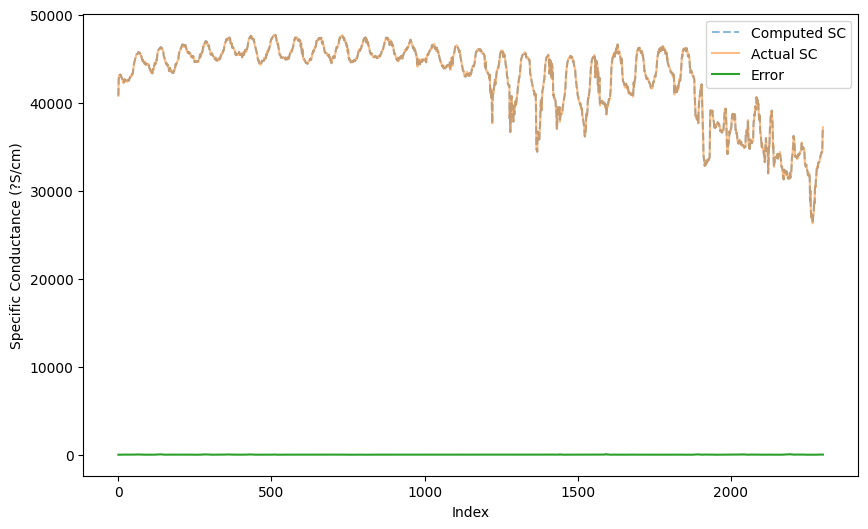

In [107]:
# optimal r=0.019558593750000013

# now we run our calculation again with the optimal r


import matplotlib.pyplot as plt


r_value = 0.019558593750000013
paul_r_value = 0.01963

computed_sc_values = []
actual_sc_values = []
error_values = []

for index, row in con_data.iterrows():
    computed_sc = specific_conductance(row["CONDUCTIVITY (?S/cm)  #21742582"], row["Temp (Â°C)  #21742582"], r_value)
    computed_sc_values.append(computed_sc)
    actual_sc_values.append(row["Specific Conductance (?S/cm)"])
    error_values.append(abs(computed_sc - row["Specific Conductance (?S/cm)"]))

# Plotting the computed and actual specific conductance values
plt.figure(figsize=(10, 6))
plt.plot(computed_sc_values, label='Computed SC', linestyle='--', alpha=0.5)
plt.plot(actual_sc_values, label='Actual SC', alpha=0.5)
plt.plot(error_values, label='Error')
plt.xlabel('Index')
plt.ylabel('Specific Conductance (?S/cm)')
plt.legend()
plt.show()


In [109]:
# they line up perfectly with 0 error
max(error_values)

66.70530118656097

# STEP 2: with specific conductivity -- you can calculate salinity.  Then you can also calculate adjusted DO (salinity adjusted DO), from the formulas Paul shared



In [30]:
def specific_conductance(AC: float, T: float, r=0.19558593750000013) -> float:
    """
    Compute the specific conductance given conductivity, temperature, and coefficient r.
    return AC / (1 + r * (T - 25))

    Parameters:
    AC (float): Actual Conductivity of the sample in microSeimens / cm
    T (float): temperature of the sample in degrees C
    r (float): temperature correction coefficient

    Returns:
    float: Specific Conductance in microSeimens / cm
    """
    return AC / (1 + r * (T - 25))

In [41]:
DO_data = pd.read_csv('../data/W12_DO_7_6_2023_lkg.csv', encoding='iso-8859-1')

In [42]:
DO_data.columns

Index(['Date Time', 'DO conc (mg/L)  #21755290', 'Temp (Â°C)  #21755290',
       'DO Adj Conc noYSI_DOcalibration (mg/L) c:1 2',
       'DO Percent Sat noYSI_DOcalibration (%)', 'Salinity (ppt)',
       'Coupler Attached', 'Stopped', 'End Of File'],
      dtype='object')

In [35]:
import numpy as np

# Constants for calculating salinity and salinity correction factor

# Coefficients for the polynomial used in the calculation of salinity
a = [0.008, -0.1692, 25.3851, 14.0941, -7.0261, 2.7081]
b = [0.0005, -0.0056, -0.0066, -0.0375, 0.0636, -0.0144]

# Constant used in the calculation of salinity
k = 0.0162

# Coefficients for the polynomial used in the calculation of rT
C = [6.766097e-01, 2.005640e-02, 1.104259e-04, -6.969800e-07, 1.003100e-09]

# Coefficients for the polynomial used in the calculation of Salinity Correction Factor
B = [-6.246090e-3, -7.423444e-3, -1.048635e-2, -7.987907e-3]

# Constant used in the calculation of Salinity Correction Factor
C0 = -4.679983e-7

In [98]:
def calculate_Rt(CS_t: float, T: float) -> float:
    """
    Calculate Rt which is the ratio of specific conductance to rT.

    Parameters:
    CS_t (float): Specific Conductance
    T (float): Water temperature in degrees C

    Returns:
    float: The calculated Rt value
    """

    R = CS_t / 42.914
    rT = sum([C[i] * (T**i) for i in range(len(C))])
    return R / rT


def calculate_salinity(CS_t: float, T: float, a: list, b: list, k: float) -> float:
    """
    Calculate Salinity based on specific conductance and temperature.

    Parameters:
    CS_t (float): Specific Conductance
    T (float): Water temperature in degrees C
    a (list): Coefficients a for the salinity calculation
    b (list): Coefficients b for the salinity calculation
    k (float): Coefficient k for the salinity calculation

    Returns:
    float: The calculated salinity value
    """
    

    Rt = calculate_Rt(CS_t, T)
    
    # Calculation for the first part of the salinity
    first_part = sum([a[i] * (Rt ** (0.5 * i)) for i in range(6)])
    
    # Calculation for the second part (inside the parentheses)
    second_part = sum([b[i] * (Rt ** (0.5 * i)) for i in range(6)])
    
    salinity = first_part + (T - 15) * second_part / (1 + k * (T - 15))

    return salinity



def calculate_TS(TC: float) -> float:
    """
    Calculate TS which is a function of temperature.

    Parameters:
    TC (float): Temperature in degrees C

    Returns:
    float: The calculated TS value
    """
    return np.log((298.15 - TC) / (273.15 + TC))


def calculate_SC(S: float, TC: float) -> float:
    """
    Calculate Salinity Correction Factor based on salinity and temperature.

    Parameters:
    S (float): Salinity
    TC (float): Temperature in degrees C

    Returns:
    float: The calculated Salinity Correction Factor
    """
    TS = calculate_TS(TC)
    ln_SC = S * sum([B[i] * (TS**i) for i in range(len(B))]) + C0 * (S**2)

    return np.exp(ln_SC)

def specific_conductance(AC: float, T: float, r=0.19558593750000013) -> float:
    """
    Compute the specific conductance given conductivity, temperature, and coefficient r.
    return AC / (1 + r * (T - 25))

    Parameters:
    AC (float): Actual Conductivity of the sample in microSeimens / cm
    T (float): temperature of the sample in degrees C
    r (float): temperature correction coefficient

    Returns:
    float: Specific Conductance in microSeimens / cm
    """
    return AC / (1 + r * (T - 25))


def adjusted_DO(DO_FIELD_CAL: float, AC: float, T_do: float, T_con: float) -> float:
    """
    Calculate adjusted dissolved oxygen concentration which takes into account salinity.

    Parameters:
    DO_FIELD_CAL (float): Field calibration of dissolved oxygen
    CS_t (float): Specific Conductance
    T (float): Water temperature in degrees C

    Returns:
    float: The adjusted dissolved oxygen concentration
    """
    CS_t = specific_conductance(AC, T_con)
    S = calculate_salinity(CS_t, T_con, a, b, k)
    SC = calculate_SC(S, T_con)
    return DO_FIELD_CAL * SC


In [43]:
DO_data.shape


(2302, 9)

In [44]:
con_data.shape

(2302, 9)

In [84]:
AC_values = con_data['CONDUCTIVITY (?S/cm)  #21742582']
temp_con_values = con_data['Temp (Â°C)  #21742582']
temp_do_values = DO_data['Temp (Â°C)  #21755290']
DO_FIELD_CAL_values = DO_data['DO conc (mg/L)  #21755290']

In [100]:
# Now we go from raw conductivity to adjusted DO
"""
Index(['Date Time', 'DO conc (mg/L)  #21755290', 'Temp (Â°C)  #21755290',
    'DO Adj Conc noYSI_DOcalibration (mg/L) c:1 2',
    'DO Percent Sat noYSI_DOcalibration (%)', 'Salinity (ppt)',
    'Coupler Attached', 'Stopped', 'End Of File'],
    dtype='object')

"""

computed_DO_values = []
actual_DO_values = []
difference_DO_values = []

for index, row in DO_data.iterrows():
    computed_DO = adjusted_DO(row['DO conc (mg/L)  #21755290'], AC_values[index], row['Temp (Â°C)  #21755290'], temp_con_values[index])
    computed_DO_values.append(computed_DO)
    actual_DO_values.append(row["DO Adj Conc noYSI_DOcalibration (mg/L) c:1 2"])
    difference_DO_values.append(abs(computed_DO - row["DO Adj Conc noYSI_DOcalibration (mg/L) c:1 2"]))


/var/folders/x4/08tn3g4d0md6km6jl5yvzx_w0000gn/T/ipykernel_62957/1972825883.py:37: RuntimeWarning: invalid value encountered in scalar power
  first_part = sum([a[i] * (Rt ** (0.5 * i)) for i in range(6)])
/var/folders/x4/08tn3g4d0md6km6jl5yvzx_w0000gn/T/ipykernel_62957/1972825883.py:40: RuntimeWarning: invalid value encountered in scalar power
  second_part = sum([b[i] * (Rt ** (0.5 * i)) for i in range(6)])


In [103]:
actual_DO_values

[7.805825977,
 8.187250745,
 8.286770369,
 8.283737527,
 8.25404184,
 8.203864602,
 8.18530583,
 8.221649494,
 8.241171554,
 8.283481605,
 8.34925568,
 8.402706845,
 8.448253361,
 8.523161312,
 8.547823196,
 8.562695136,
 8.594617316,
 8.586664258,
 8.446858004,
 8.447063315,
 8.567660302,
 8.589165941,
 8.577678072,
 8.618305834,
 8.658582758,
 8.704285524,
 8.705748076,
 8.692488317,
 8.717464842,
 8.708537145,
 8.695872785,
 8.640509654,
 8.71113027,
 8.77927015,
 8.820823709,
 8.881357831,
 8.934118368,
 9.0412641,
 9.188284106,
 9.12800074,
 9.256267588,
 9.29023432,
 9.253879062,
 9.220235039,
 9.270534996,
 9.338579764,
 9.368424422,
 9.342637483,
 9.201499425,
 9.109954833,
 8.98643934,
 8.963751299,
 8.914004499,
 8.839918956,
 8.784984276,
 8.707994386,
 8.669277341,
 8.632477707,
 8.555075629,
 8.552394046,
 8.509229528,
 8.491498535,
 8.457902101,
 8.431649639,
 8.395637335,
 8.339733718,
 8.334232232,
 8.284130526,
 8.23377107,
 8.219947799,
 8.205299581,
 8.103051849,
 8.

2302